In [ ]:
# © Begum Celebi, December 2025 
# --------------------------------------------------------
# FTSE 100 vs BIST 100 Portfolio Analysis
# --------------------------------------------------------
# Date: 2025-12-27
# Data Source: Investing.com
#
# Objective:
#   Analyze the relationship between FTSE 100 (UK) and BIST 100 (Turkey)
#   using daily and monthly returns, risk-free yields, and risk-adjusted metrics.
#   Includes:
#       - Daily returns comparison
#       - 30-day rolling correlation
#       - Monthly risk-return scatter
#       - Sharpe ratios and annualized metrics
#
# Data Assumptions:
#   - Risk-free rates from 3-month government securities
#   - Daily equity returns calculated from percentage changes
#   - All yields annualized in decimal form
#   - Local currency analysis (no FX adjustment)
#
# Notes:
#   - This is a portfolio-focused student-level analysis.
#   - Sharpe ratios are calculated using excess returns over risk-free rates.
# --------------------------------------------------------



--- RISK & PERFORMANCE SUMMARY ---
FTSE 100 Annual Return: 9.03%
BIST 100 Annual Return: 43.45%

FTSE 100 Volatility: 12.73%
BIST 100 Volatility: 28.31%

FTSE 100 Sharpe Ratio (UK RF): -16.84
BIST 100 Sharpe Ratio (TR RF): -29.45

Average Correlation: 0.22


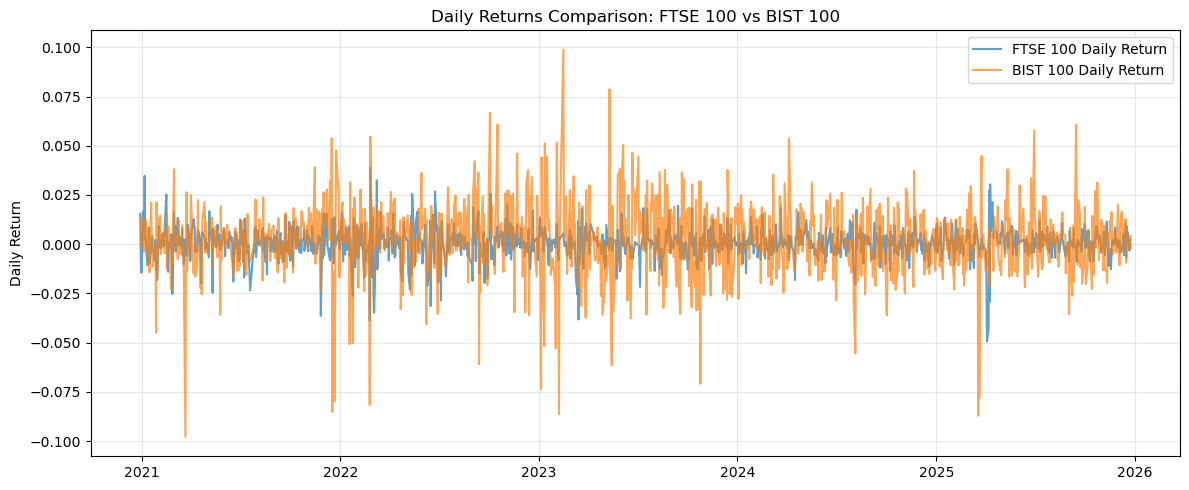

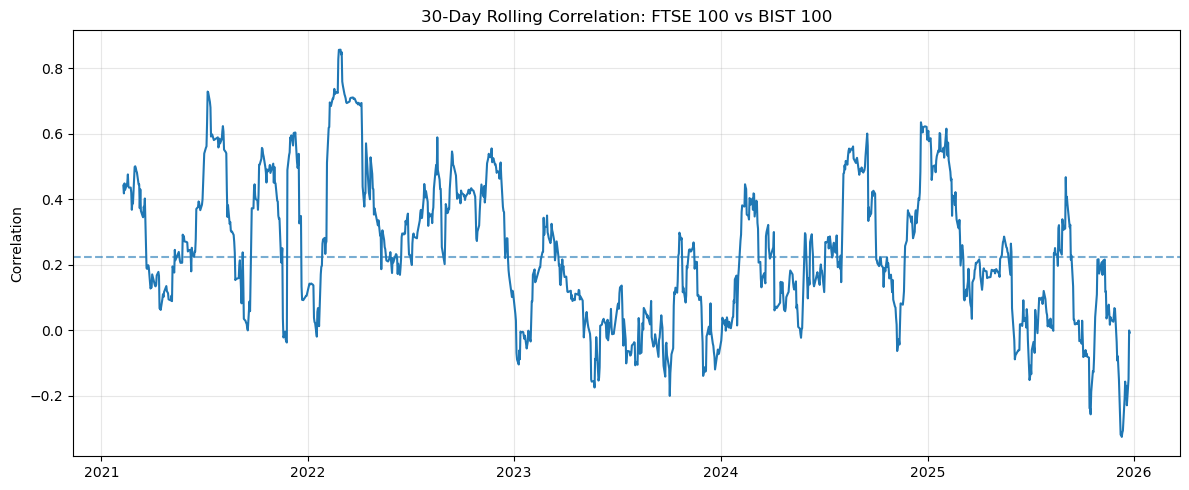

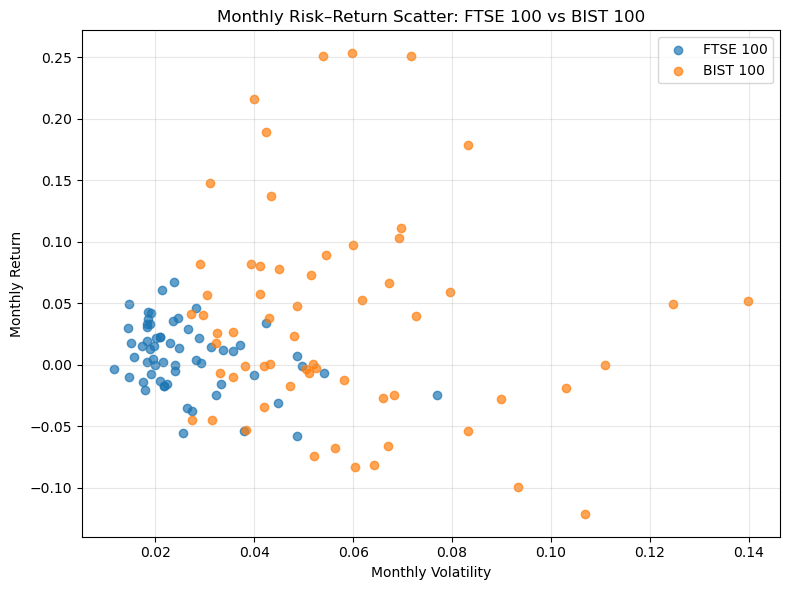

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# FTSE 100 vs BIST 100 Portfolio Analysis
# =========================================================
# Author: Your Name
# Date: 2025-12-27
#
# Objective:
#   Analyze FTSE 100 (UK) vs BIST 100 (Turkey) with daily returns,
#   risk-free yields, and risk-adjusted metrics.
#   Includes:
#       - Daily returns comparison
#       - 30-day rolling correlation
#       - Monthly risk-return scatter
#       - Rolling 12-month volatility of monthly returns (annualised)
# =========================================================

# -----------------------------
# 1. LOAD EQUITY DATA
# -----------------------------
ftse = pd.read_csv('ftse_100 .csv')
bist = pd.read_csv('bist_100 .csv')

ftse['date'] = pd.to_datetime(ftse['date'], dayfirst=True)
bist['date'] = pd.to_datetime(bist['date'], dayfirst=True)

ftse['ftse_change'] = pd.to_numeric(ftse['ftse_change'], errors='coerce')
bist['bist_change'] = pd.to_numeric(bist['bist_change'], errors='coerce')

df = pd.merge(
    ftse[['date', 'ftse_change']],
    bist[['date', 'bist_change']],
    on='date',
    how='inner'
).sort_values('date').reset_index(drop=True)

# -----------------------------
# 2. LOAD RISK-FREE YIELD DATA
# -----------------------------
uk_rf = pd.read_csv('uk_three_month_gov_bond .csv')
tr_rf = pd.read_csv('turkey_three_month_gov_bill .csv')

uk_rf['date'] = pd.to_datetime(uk_rf['date'], dayfirst=True)
tr_rf['date'] = pd.to_datetime(tr_rf['date'], dayfirst=True)

uk_rf['uk_rf_daily'] = uk_rf['uk_3month_yield'] / 252
tr_rf['tr_rf_daily'] = tr_rf['turkey_3month_yield'] / 252

df = df.merge(uk_rf[['date', 'uk_rf_daily']], on='date', how='left')
df = df.merge(tr_rf[['date', 'tr_rf_daily']], on='date', how='left')

df[['uk_rf_daily', 'tr_rf_daily']] = df[['uk_rf_daily', 'tr_rf_daily']].ffill()

# -----------------------------
# 3. EXCESS RETURNS
# -----------------------------
df['ftse_excess'] = df['ftse_change'] - df['uk_rf_daily']
df['bist_excess'] = df['bist_change'] - df['tr_rf_daily']

# -----------------------------
# 4. RISK & PERFORMANCE METRICS
# -----------------------------
trading_days = 252

ftse_return = df['ftse_change'].mean() * trading_days
bist_return = df['bist_change'].mean() * trading_days

ftse_vol = df['ftse_change'].std() * np.sqrt(trading_days)
bist_vol = df['bist_change'].std() * np.sqrt(trading_days)

ftse_sharpe = (df['ftse_excess'].mean() / df['ftse_excess'].std()) * np.sqrt(trading_days)
bist_sharpe = (df['bist_excess'].mean() / df['bist_excess'].std()) * np.sqrt(trading_days)

corr = df['ftse_change'].corr(df['bist_change'])

# -----------------------------
# 5. PRINT SUMMARY
# -----------------------------
print("\n--- RISK & PERFORMANCE SUMMARY ---")
print(f"FTSE 100 Annual Return: {ftse_return:.2%}")
print(f"BIST 100 Annual Return: {bist_return:.2%}\n")

print(f"FTSE 100 Volatility: {ftse_vol:.2%}")
print(f"BIST 100 Volatility: {bist_vol:.2%}\n")

print(f"FTSE 100 Sharpe Ratio (UK RF): {ftse_sharpe:.2f}")
print(f"BIST 100 Sharpe Ratio (TR RF): {bist_sharpe:.2f}\n")

print(f"Average Correlation: {corr:.2f}")

# -----------------------------
# 6. DAILY RETURNS COMPARISON
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['ftse_change'], label='FTSE 100 Daily Return', alpha=0.7)
plt.plot(df['date'], df['bist_change'], label='BIST 100 Daily Return', alpha=0.7)
plt.title('Daily Returns Comparison: FTSE 100 vs BIST 100')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. 30-DAY ROLLING CORRELATION
# -----------------------------
df['rolling_corr_30d'] = df['ftse_change'].rolling(window=30, min_periods=1).corr(df['bist_change'])

plt.figure(figsize=(12, 5))
plt.plot(df['date'].iloc[29:], df['rolling_corr_30d'].iloc[29:])
plt.axhline(corr, linestyle='--', alpha=0.6)
plt.title('30-Day Rolling Correlation: FTSE 100 vs BIST 100')
plt.ylabel('Correlation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 8. MONTHLY RETURNS
# -----------------------------
df_monthly = df.set_index('date').resample('ME').apply(lambda x: (1 + x).prod() - 1)

monthly_returns = df_monthly[['ftse_change', 'bist_change']]
monthly_vol = df.set_index('date')[['ftse_change','bist_change']].resample('ME').std() * np.sqrt(12)

# -----------------------------
# 9. MONTHLY RISK–RETURN SCATTER
# -----------------------------
monthly_stats = pd.DataFrame({
    'FTSE_return': monthly_returns['ftse_change'],
    'BIST_return': monthly_returns['bist_change'],
    'FTSE_vol': monthly_vol['ftse_change'],
    'BIST_vol': monthly_vol['bist_change']
}).dropna()

plt.figure(figsize=(8, 6))
plt.scatter(monthly_stats['FTSE_vol'], monthly_stats['FTSE_return'], alpha=0.7, label='FTSE 100')
plt.scatter(monthly_stats['BIST_vol'], monthly_stats['BIST_return'], alpha=0.7, label='BIST 100')
plt.xlabel('Monthly Volatility')
plt.ylabel('Monthly Return')
plt.title('Monthly Risk–Return Scatter: FTSE 100 vs BIST 100')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 10. ROLLING 12-MONTH VOLATILITY (ANNUALISED)
# -----------------------------
rolling_12m_vol = monthly_returns.rolling(window=12).std() * np.sqrt(12)

plt.figure(figsize=(12, 5))
plt.plot(rolling_12m_vol.index, rolling_12m_vol['ftse_change'], label='FTSE 100')
plt.plot(rolling_12m_vol.index, rolling_12m_vol['bist_change'], label='BIST 100')
plt.title('Rolling 12-Month Volatility of Monthly Returns (Annualised)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
